<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Classification/Notebooks/Classification_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Classification Exploratory Data Analysis

### Introduction

This project will seek to use supervised classification techniques for fault detection with geospatial imagery. 10 rasters will be used as X data with a binary raster of fault lines as the labeled data. Training data is of an extent roughly 60x60 km north east of Reno, NV in the United States. It will be split into training and test sets to measure model performance. Higher performing models will be applied to a dataset, without labeled data, with an extent of about 45x45 km directly north of the Vatnajökull glacier in Iceland. X imagery will consist of Landsat bands 2-7 (rgb, near infrared, and 2 short-wave infrared bands), a digital elevation model (DEM), clay minerals ratio (CMI) derived from from bands 6 and 7, and aspect and slope derived from the DEM. The Nevada DEM was retrieved from the US environmental protection agency (EPA) web archive. The Iceland DEM was retrieved from the University of Minnesota's FRIDGE datahub. The fault raster was created from US fault data retrieved from Esri's Living Atlas.

### Data Retrieval and Preprocessing

Extensive preprocessing is required to make the dataset meaningful and usable in machine learning algorithms. Preliminary preprocessing steps were made using Esri's ArcGIS Pro software. These steps were clipping rasters to a smaller extent, creating a binary raster from fault polylines, and some resampling. Imagery that needs to be calculated from the original data will be done later below as well as some resampling and more clipping.

rasterio is a popular python library for processing geospatial imagery and will the primary package used until preprocessing is completed and a final numpy array remains with the necesarry data.

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 13.3 MB/s eta 0:00:00


First, Nevada imagery is retrieved from the project repository on GitHub.

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import gc
from rasterio.warp import reproject, Resampling
import requests
import os
import pandas as pd
import glob

repo_api_url = "https://api.github.com/repos/GeoLinkCoding/EarthResources_DataScience/contents/Classification/Data"
response = requests.get(repo_api_url).json()

# Extract filenames
files = [file["download_url"] for file in response if file["type"] == "file"]
for file in files:
    os.system(f"wget {file}")

raster_files = glob.glob("N*")
raster_files.sort()
print(raster_files)

['NevadaB2.tif', 'NevadaB3.tif', 'NevadaB4.tif', 'NevadaB5.tif', 'NevadaB6.tif', 'NevadaB7.tif', 'NevadaDEM.tif', 'NevadaFault.tif']


Next, we inspect the metadata and shape of some of the imagery. The DEM and fault image have different shapes from the landsat so this will need to fixed later. Also, preliminary tests proved that the datasets are still too large so they will be further reduced.

In [3]:
blue_band = raster_files[0]
with rasterio.open(blue_band) as src:
    img = src.read(1)
    metadata = src.meta
    rows, cols = img.shape
print(metadata)
print(f'Blue band shape: {img.shape}')

dem = raster_files[6]
with rasterio.open(dem) as src:
    img = src.read(1)
print(f'DEM shape: {img.shape}')

fault_raster = raster_files[7]
with rasterio.open(fault_raster) as src:
    img = src.read(1)
print(f'Fault raster shape: {img.shape}')

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 4052, 'height': 3930, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'), 'transform': Affine(30.0, 0.0, 284295.0,
       0.0, -30.0, 4484625.0)}
Blue band shape: (3930, 4052)
DEM shape: (5037, 5180)
Fault raster shape: (5036, 5179)


We'll store all the preprocessed rasters in the "imgs" variable, starting with the 6 landsat bands. Pixels with nodata values are replaced with np.nan and the image is clipped to a smaller extent. The "imgs" variable now has 6 rasters and 5 empty arrays.

Landsat bands shape: (11, 2000, 2000)


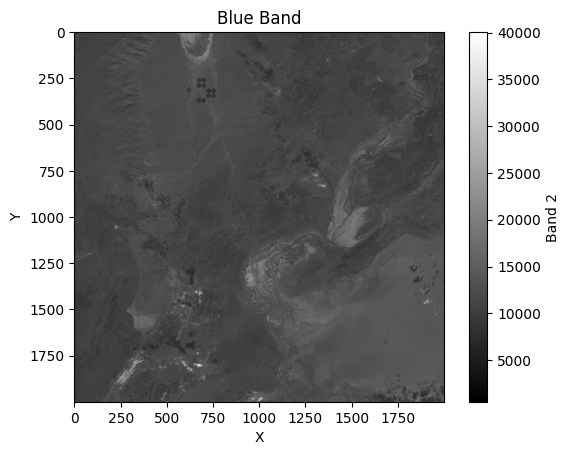

In [4]:
imgs = np.empty((11,2000,2000))
for i in range(6):
    with rasterio.open(raster_files[i]) as src:
        nodata_value = src.nodata
        window = rasterio.windows.Window.from_slices((1000,3000),(1000,3000))
        img = src.read(1, window=window)
        imgs[i,:,:] = np.where(img == src.nodata, np.nan, img)
print(f'Landsat bands shape: {imgs.shape}')
plt.imshow(imgs[0,:,:], cmap='grey')
plt.colorbar(label='Band 2')
plt.title('Blue Band')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

The first derived raster is the clay minerals ratio which is calculated from SWIR 1/SWIR 2 or band 6/band 7. Faults can often have higher clay content due to hydrothermal activity or enhanced weathering so this ratio is a useful addition.

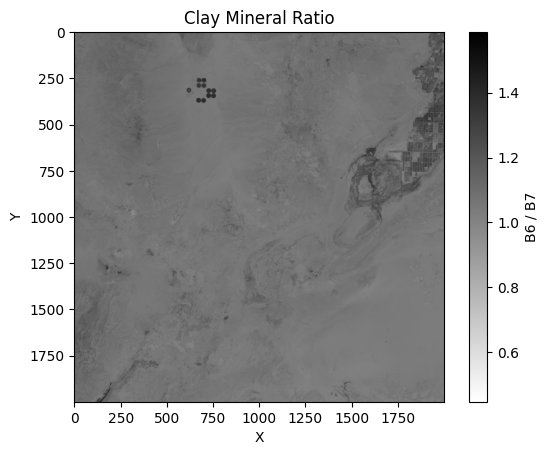

In [5]:
b6 = imgs[4,:,:]
b7 = imgs[5,:,:]
# Calculate the new raster (B6 / B7)
# Replace 0 values in b6 to avoid division by zero  # Replace with NaN or a small value
CMI = np.divide(b6, b7, out=np.zeros_like(b6, dtype=float), where=b7 != 0)
imgs[6,:,:] = CMI
# Plot the new raster
plt.imshow(CMI, cmap='grey_r')  # Choose a suitable colormap
plt.colorbar(label='B6 / B7')
plt.title('Clay Mineral Ratio')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Here we resample the DEM and fault labels to match the resolution and shape of the landsat bands. The DEM is resampled bilinearly since it's continuous, but the fault raster was resampled by nearest to preserve classified labels. Images are clipped to the same extent as the landsat and nodata values are replaced.

In [6]:
reference_band = raster_files[0]
with rasterio.open(reference_band) as ref:
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_width = ref.width
    ref_height = ref.height

dem = raster_files[6]
with rasterio.open(dem) as src:
    nodata_value = src.nodata
    dem_resampled = np.empty((ref_height, ref_width), dtype=np.float32)
    src.read(1, out = dem_resampled,
                        resampling=Resampling.bilinear)
    dem_clipped = dem_resampled[1000:3000, 1000:3000]
    dem_clipped = np.where(dem_clipped == nodata_value, np.nan, dem_clipped)
print(f'DEM new shape: {dem_clipped.shape}')

fault_raster = raster_files[7]
with rasterio.open(fault_raster) as src:
    nodata_value = src.nodata
    fault_resampled = np.empty((ref_height, ref_width), dtype=np.float32)
    src.read(1, out = fault_resampled,
                        resampling=Resampling.nearest)
    fault_clipped = fault_resampled[1000:3000, 1000:3000]
    fault_clipped = np.where(fault_clipped == nodata_value, np.nan, fault_clipped)
print(f'Fault new shape: {fault_clipped.shape}')
imgs[7,:,:] = dem_clipped
imgs[10,:,:] = fault_clipped

DEM new shape: (2000, 2000)
Fault new shape: (2000, 2000)


The final additions to the "imgs" array is slope and aspect, which are calculated from the DEM. Faults greatly influence terrain sloping and demonstrate consistent aspect, so these features are well worth including.

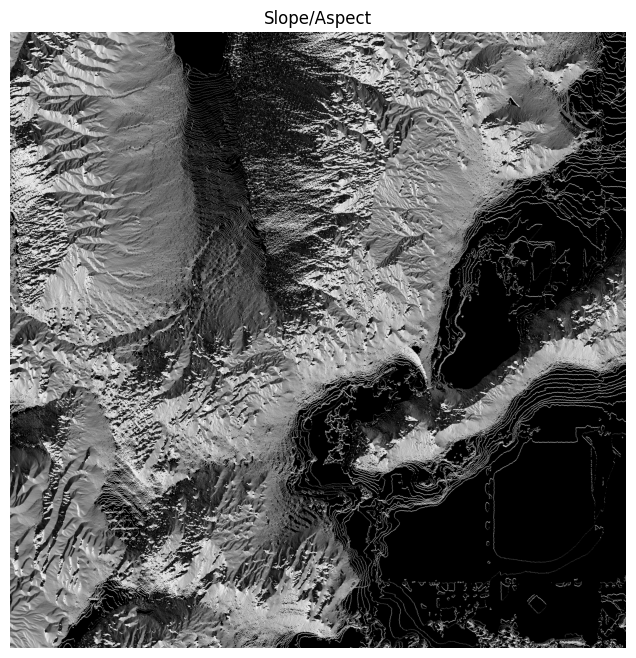

In [7]:
# Calculate resolution
x_res = 30  # Pixel width
y_res = -30  # Pixel height (negative)

# Compute gradients
gy, gx = np.gradient(imgs[7,:,:], y_res, x_res)

# Compute aspect in degrees
aspect = np.degrees(np.arctan2(gy, -gx))
slope = np.arctan(np.sqrt(gx**2 + gy**2)) * (180 / np.pi)

imgs[8,:,:] = aspect
imgs[9,:,:] = slope

slope_aspect_image = np.dstack([aspect,slope])
plt.figure(figsize=(8, 8))
plt.imshow(slope_aspect_image[:, :, 0], cmap='grey')
plt.title('Slope/Aspect')
plt.axis('off')
plt.show()

### Data Visualization

With preprocessing complete, we can explore what the data looks like. CMI and Slope/Aspect have already been shown so next we'll plot the most basic imagery composite, the red, green, blue (rgb) image. This is what the human eye would see from the same angle. Composites are normalized before plotting so nan values don't skew color mapping.

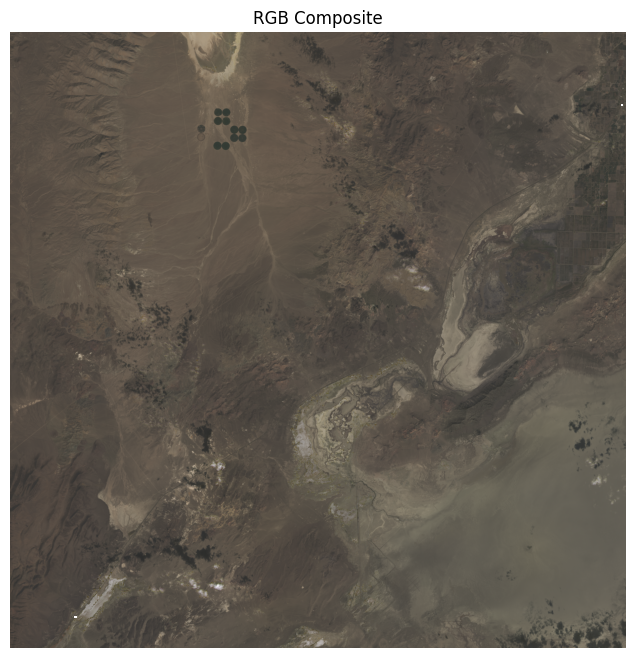

In [8]:
rgb_bands = [imgs[2, :, :], imgs[1, :, :], imgs[0, :, :]]

rgb_image = np.dstack(rgb_bands)
rgb_norm = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image))
# Plot the RGB image
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.imshow(rgb_norm)
plt.title('RGB Composite')
plt.axis('off')  # Optional: Turn off axes
plt.show()

SWIR bands can be used for false color composites that highlight geologic features. SWIR 2 values are used as red, SWIR 1 is used as green, and blue is used as blue.

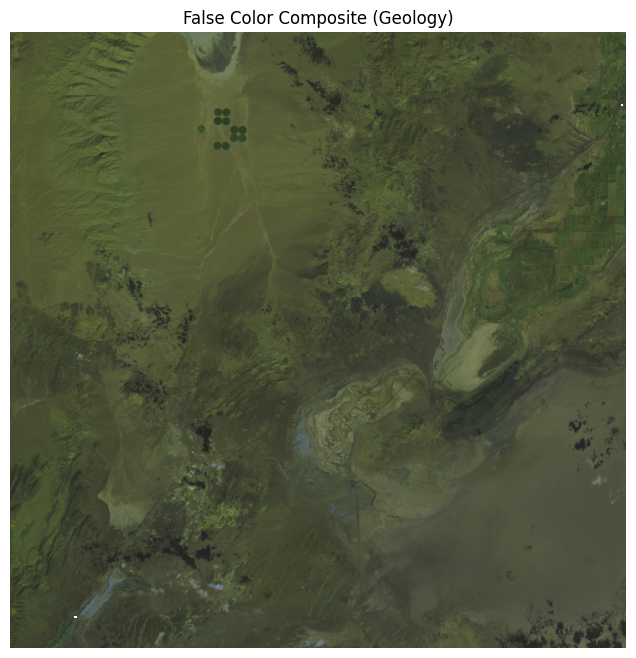

In [9]:
rgb_bands = [imgs[5, :, :], imgs[4, :, :], imgs[0, :, :]]

rgb_image = np.dstack(rgb_bands)
rgb_norm = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image))
# Plot RGB Image
plt.figure(figsize=(8, 8))
plt.imshow(rgb_norm)
plt.title('False Color Composite (Geology)')
plt.axis('off')
plt.show()

The fault raster has two values, with fault lines marked by 1 and everything else at 0.

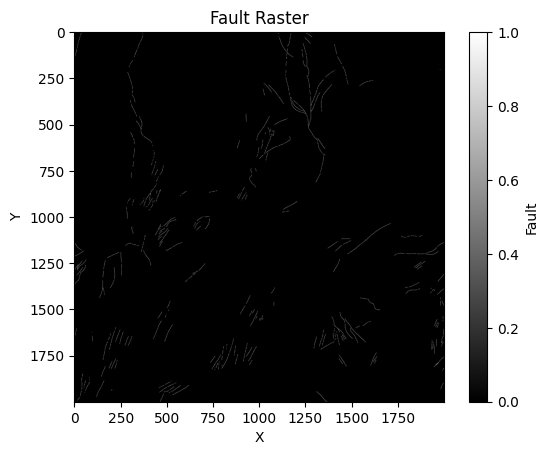

In [10]:
fault = imgs[10,:,:]
plt.imshow(fault, cmap='grey')  # Choose a suitable colormap
plt.colorbar(label='Fault')
plt.title('Fault Raster')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

To reduce RAM usage, some variables are cleared.

In [11]:
del rgb_bands, rgb_norm, rgb_image, dem_resampled, fault_resampled, b6, b7, CMI, reference_band, img, aspect, slope, gy, gx
gc.collect()


19758

### Data Analysis

Now we'll explore some statistics behind our data, starting with one we've already seen, shape, but also some individual statistics for each raster.

In [12]:
import pandas as pd
raster_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'CMI', 'DEM', 'Aspect', 'Slope', 'Fault']
print(f'Shape of full dataset: {imgs.shape}')
reshaped_imgs = imgs.reshape(imgs.shape[0], -1).T
df = pd.DataFrame(reshaped_imgs, columns=raster_names)
print('Raster Statistics:')
df.describe().round(2)

Shape of full dataset: (11, 2000, 2000)
Raster Statistics:


Blue       Green         Red         NIR       SWIR1       SWIR2  \
count  3999997.00  4000000.00  4000000.00  4000000.00  4000000.00  4000000.00   
mean     11963.80    13472.98    14632.80    16232.64    17556.44    16323.28   
std       1729.48     2137.63     2305.19     2450.64     2824.14     2602.47   
min        564.00     5102.00     6309.00     7461.00     7663.00     7641.00   
25%      10825.00    11990.00    13082.00    14632.00    15633.00    14514.00   
50%      11702.00    13224.00    14517.00    16256.00    17588.00    16412.00   
75%      12724.00    14596.00    15982.00    17621.00    19483.00    18133.00   
max      40041.00    39320.00    39887.00    38690.00    36232.00    54309.00   

              CMI         DEM      Aspect       Slope       Fault  
count  4000000.00  3999997.00  3999988.00  3999988.00  3999987.00  
mean         1.08     1348.75      -61.38        4.07        0.00  
std          0.04      182.85      114.23        5.75        0.06  
min          0.45     1177.00     -180.00        0.00        0.00  
25%          1.05     1190.00     -180.00        0.00        0.00  
50%          1.07     1292.00      -83.66        1.91        0.00  
75%          1.09     1444.00       38.37        5.13        0.00  
max          1.59     2199.00      178.92       55.91        1.00

The pairplot below will take a while to load, 3 minutes using the base CPU. When it loads it shows a comparison of rgb and fault features to each other. We notice very few fault pixels but they cover a distinct range of rgb values.

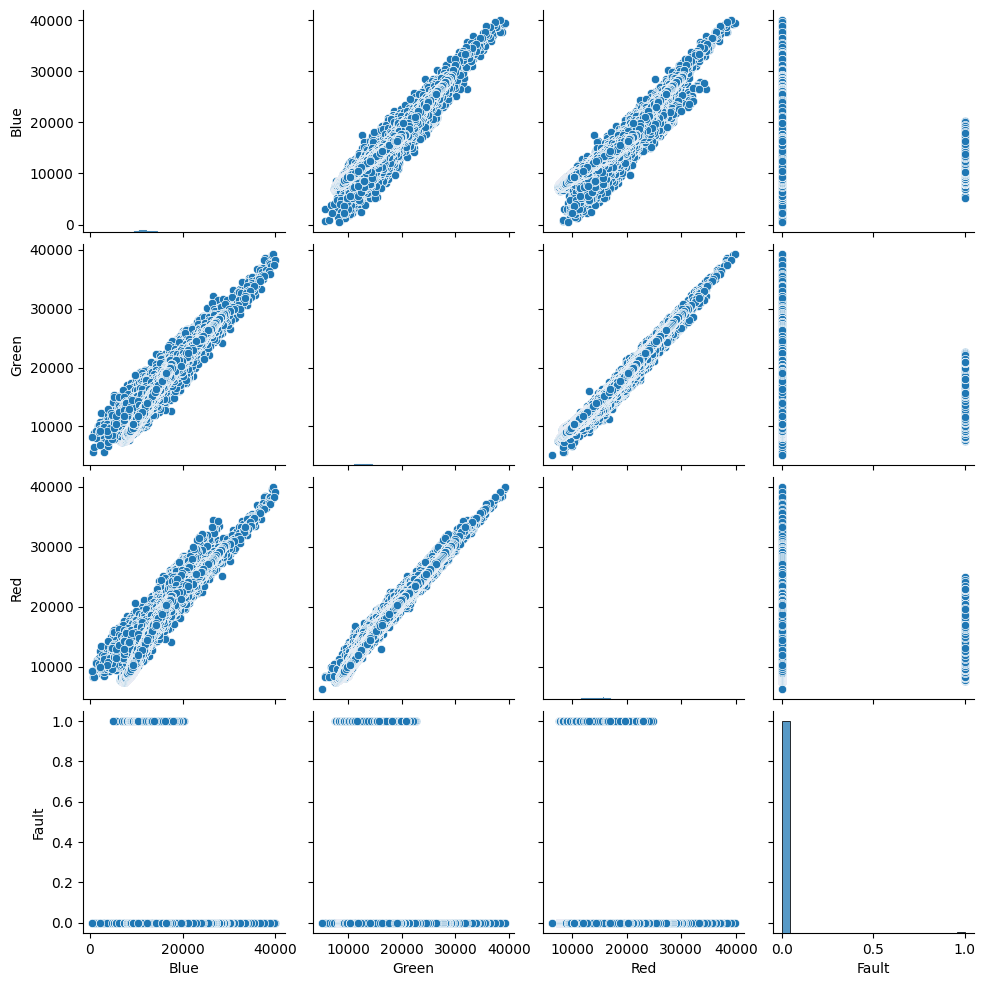

In [13]:
import seaborn as sns
vars = ['Blue', 'Green', 'Red', 'Fault']
sns.pairplot(df[vars])
plt.show()

The correlation heatmap below shows a lot of what we'd expect. Landsat bands are highly correlated with each other, CMI is slightly correlated with B6 and B7, slope and aspect are slightly correlated with DEM, and fault data which is saturated to 0 has almost no correlations.

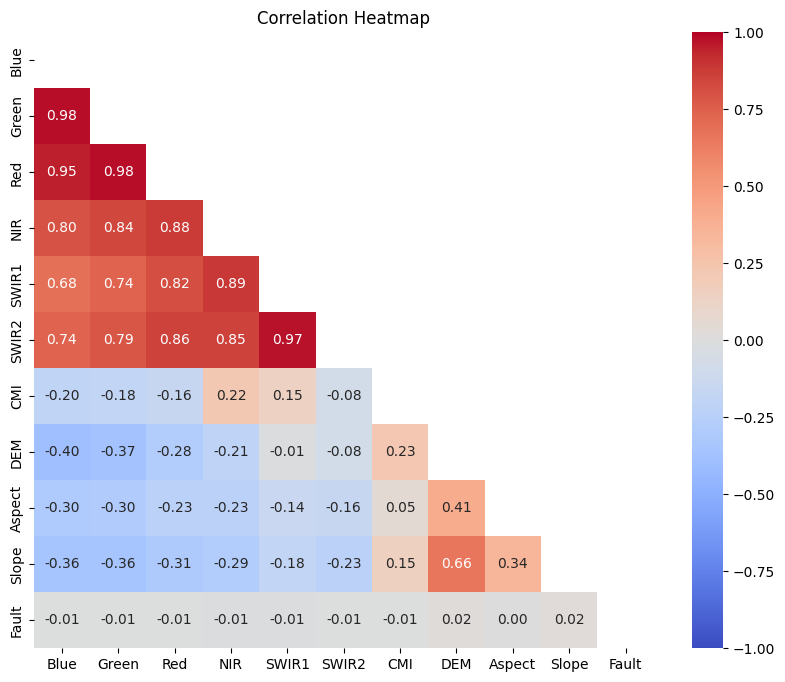

In [14]:
correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap with the mask
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

To explore the fault data compared to the other rasters, without waiting 3+ minutes, we can query the dataframe to fault values of 1. The pairplot below loads much quicker and we can view the range of values for each raster along fault lines. Compare these ranges to the min and max of each raster from the df.describe statistics a few cells above.

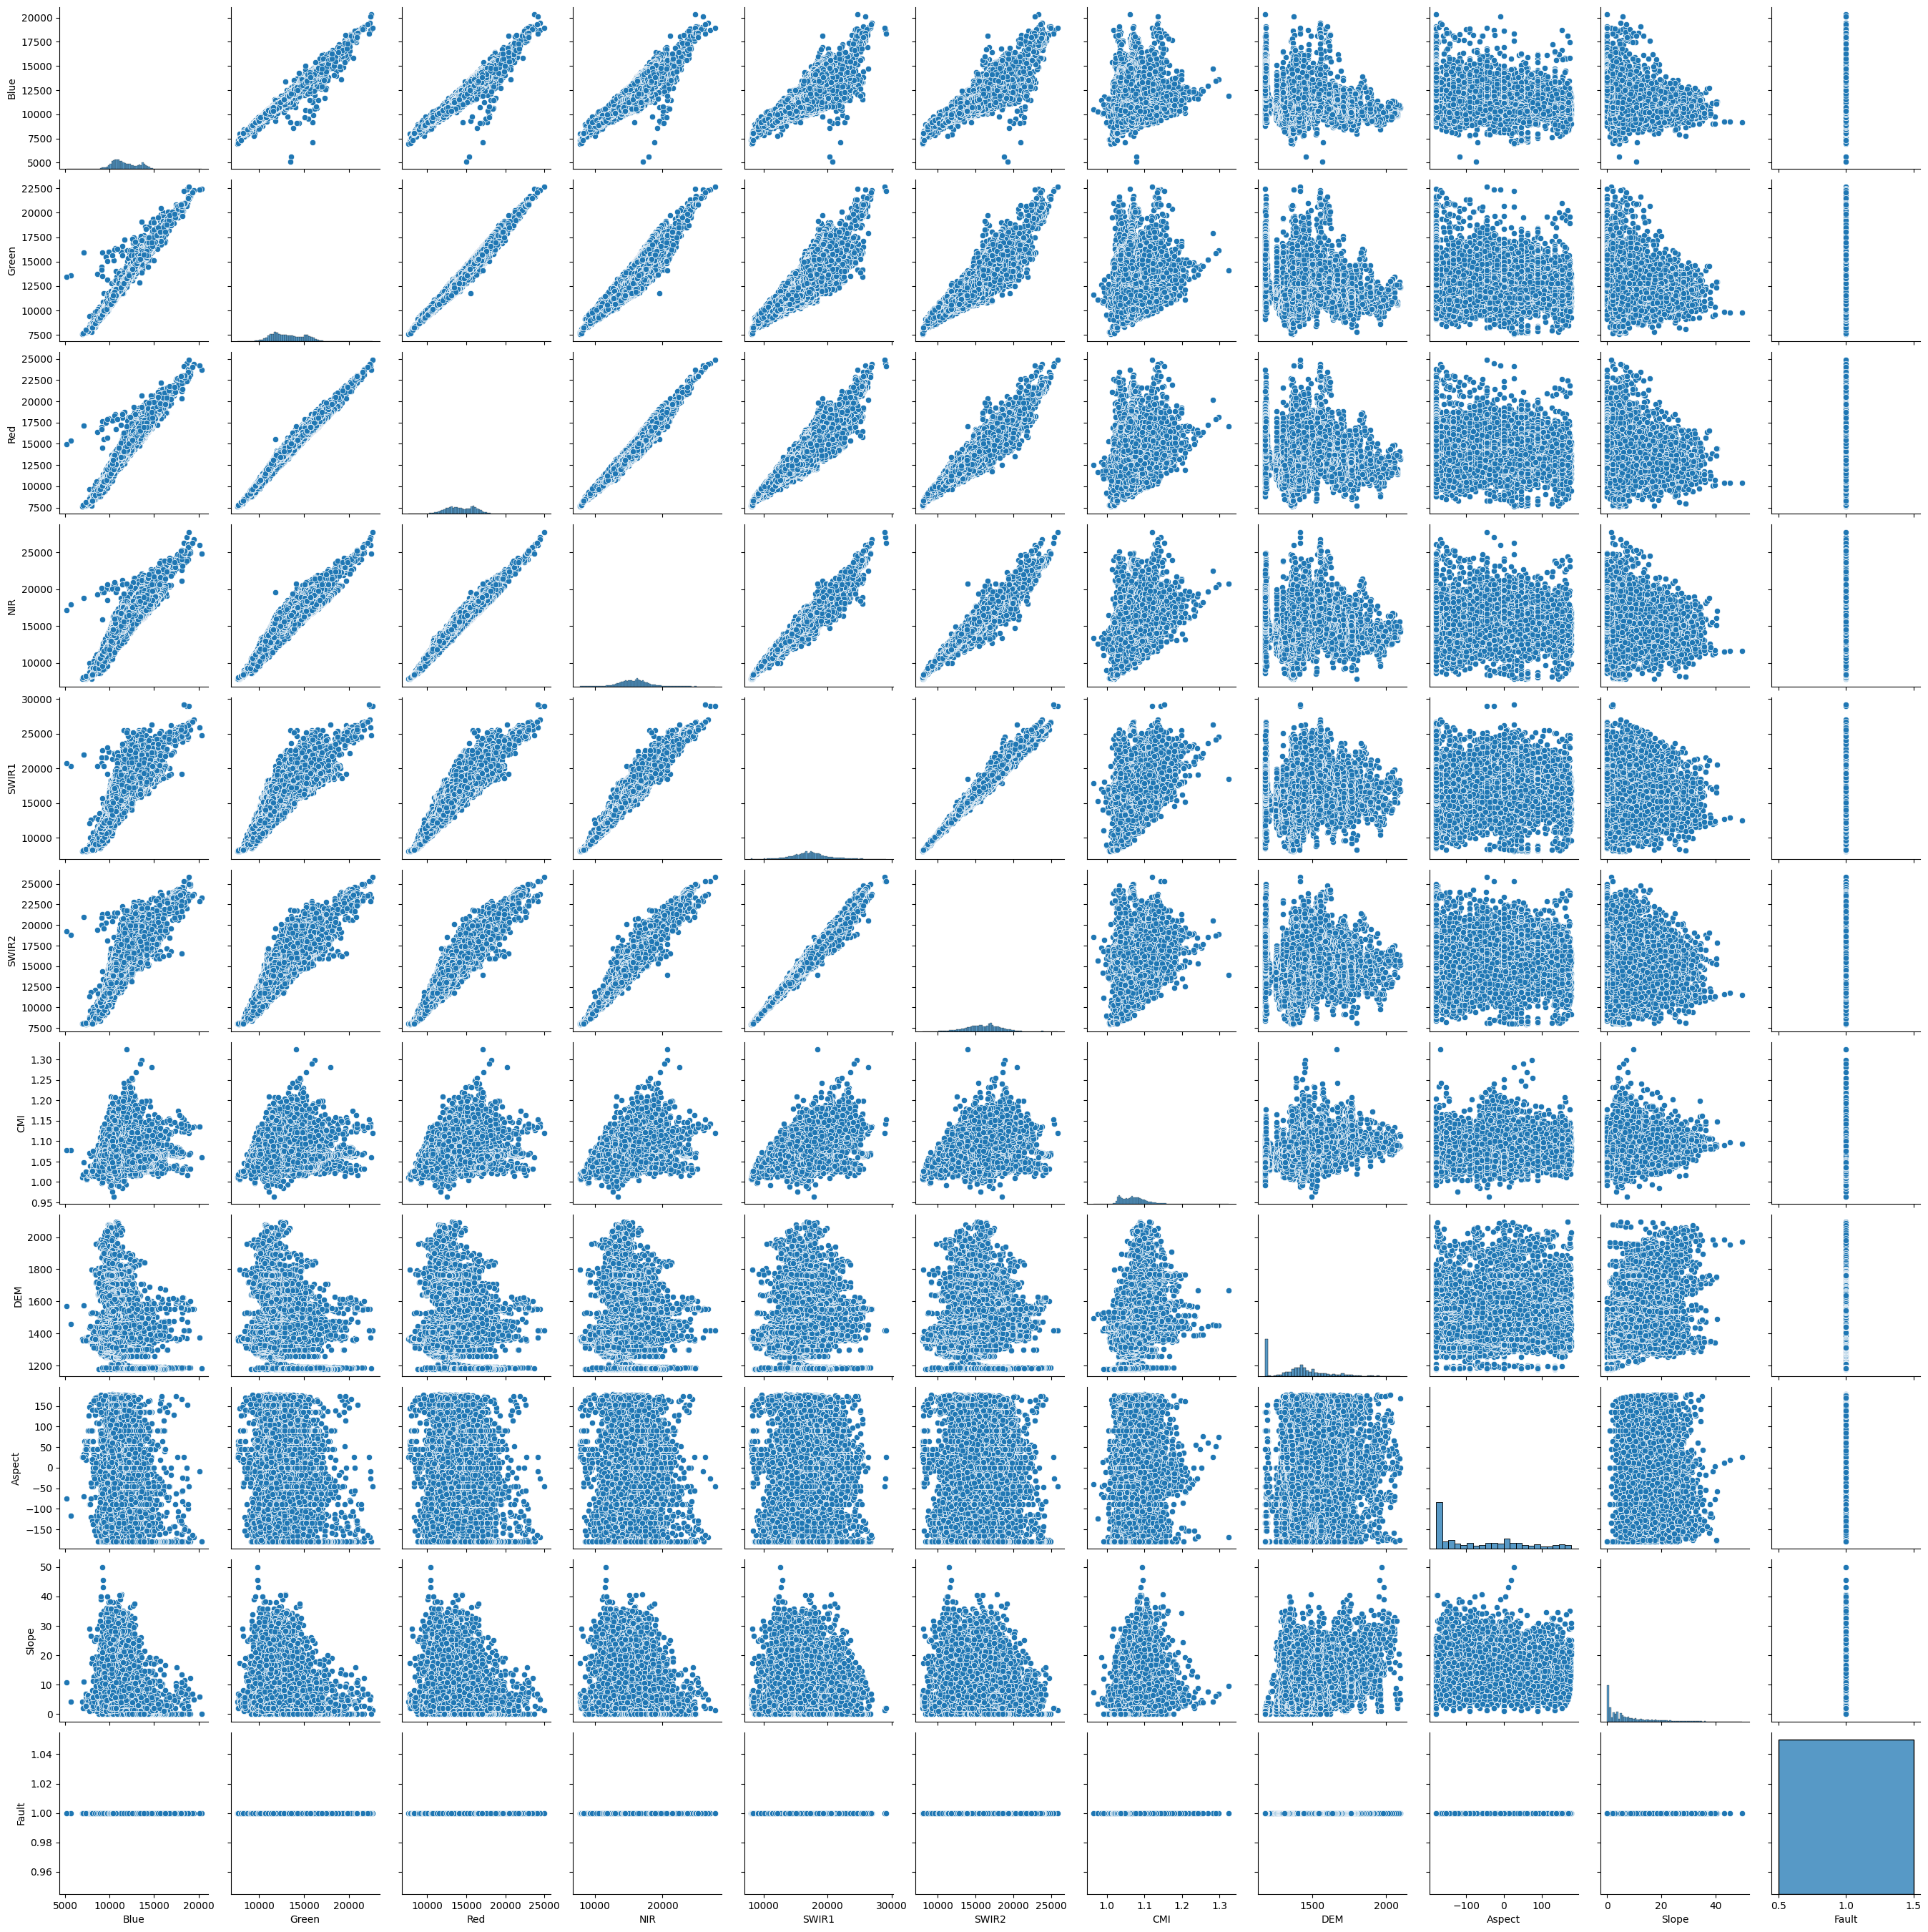

In [15]:
filtered_df = df[df['Fault'] == 1]
sns.pairplot(filtered_df)
plt.show()

### Application Data

After exploring the training, we'll load, preprocess, and plot the data from Iceland just to have a visual look.

In [16]:
raster_files = glob.glob("I*")
raster_files.sort()
print(raster_files)

['IcelandB2.tif', 'IcelandB3.tif', 'IcelandB4.tif', 'IcelandB5.tif', 'IcelandB6.tif', 'IcelandB7.tif', 'IcelandDEM.tif']


Landsat bands shape: (10, 1500, 1500)


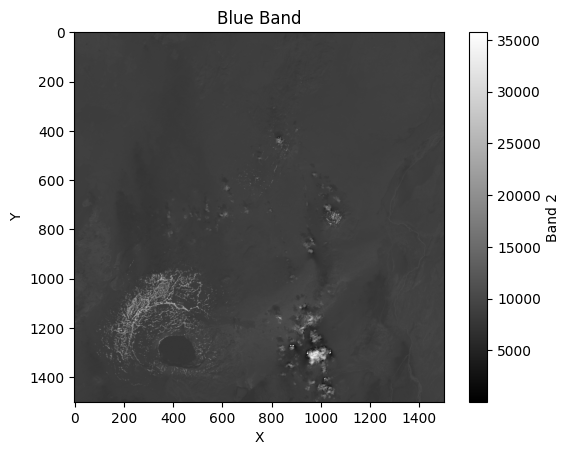

In [17]:
iceland = np.empty((10,1500,1500))
for i in range(6):
    with rasterio.open(raster_files[i]) as src:
        nodata_value = src.nodata
        window = rasterio.windows.Window.from_slices((1000,2500),(1000,2500))
        img = src.read(1, window=window)
        iceland[i,:,:] = np.where(img == src.nodata, np.nan, img)
print(f'Landsat bands shape: {iceland.shape}')
plt.imshow(iceland[0,:,:], cmap='grey')
plt.colorbar(label='Band 2')
plt.title('Blue Band')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

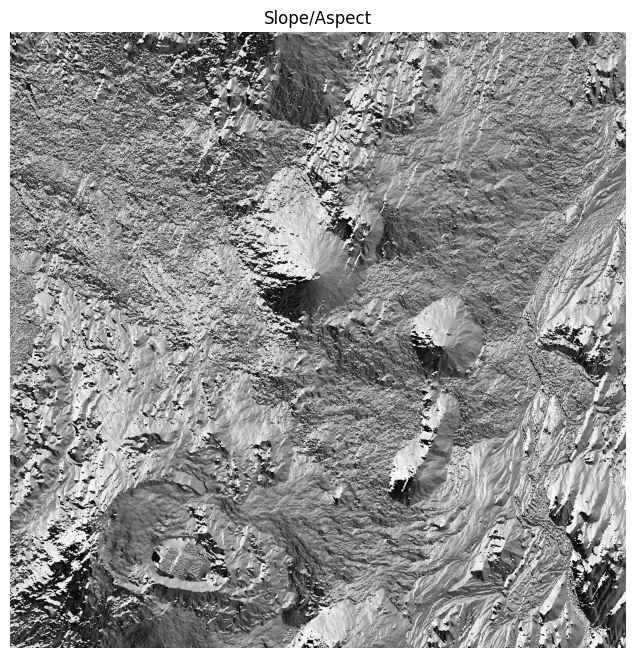

In [21]:
b6 = iceland[4,:,:]
b7 = iceland[5,:,:]
# Calculate the new raster (B6 / B7)
# Replace 0 values in b6 to avoid division by zero  # Replace with NaN or a small value
CMI = np.divide(b6, b7, out=np.zeros_like(b6, dtype=float), where=b7 != 0)
iceland[6,:,:] = CMI
with rasterio.open(raster_files[6]) as src:
    nodata_value = src.nodata
    window = rasterio.windows.Window.from_slices((1000,2500),(1000,2500))
    img = src.read(1, window=window)
    iceland[7,:,:] = np.where(img == src.nodata, np.nan, img)
x_res = 30  # Pixel width
y_res = -30  # Pixel height (negative)

# Compute gradients
gy, gx = np.gradient(iceland[7,:,:], y_res, x_res)

# Compute aspect in degrees
aspect = np.degrees(np.arctan2(gy, -gx))
slope = np.arctan(np.sqrt(gx**2 + gy**2)) * (180 / np.pi)

iceland[8,:,:] = aspect
iceland[9,:,:] = slope

slope_aspect_image = np.dstack([aspect,slope])
plt.figure(figsize=(8, 8))
plt.imshow(slope_aspect_image[:, :, 0], cmap='grey_r')
plt.title('Slope/Aspect')
plt.axis('off')
plt.show()

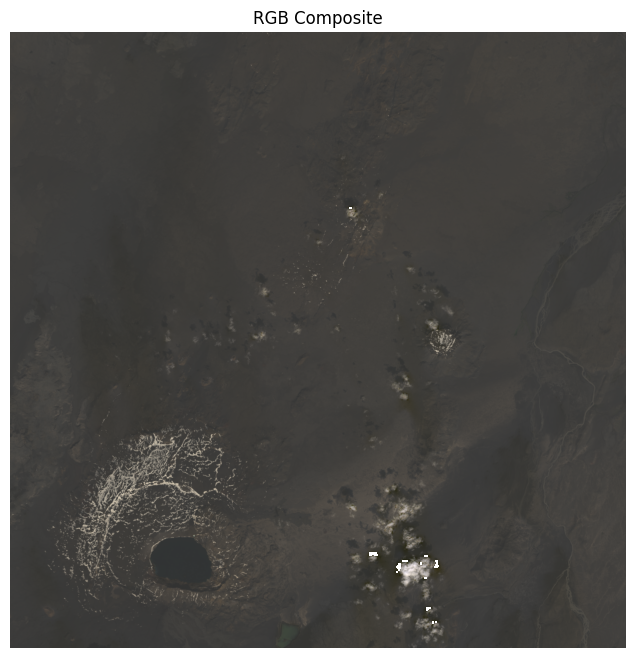

In [19]:
rgb_bands = [iceland[2, :, :], iceland[1, :, :], iceland[0, :, :]]

rgb_image = np.dstack(rgb_bands)
rgb_norm = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image))
# Plot the RGB image
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.imshow(rgb_norm)
plt.title('RGB Composite')
plt.axis('off')  # Optional: Turn off axes
plt.show()

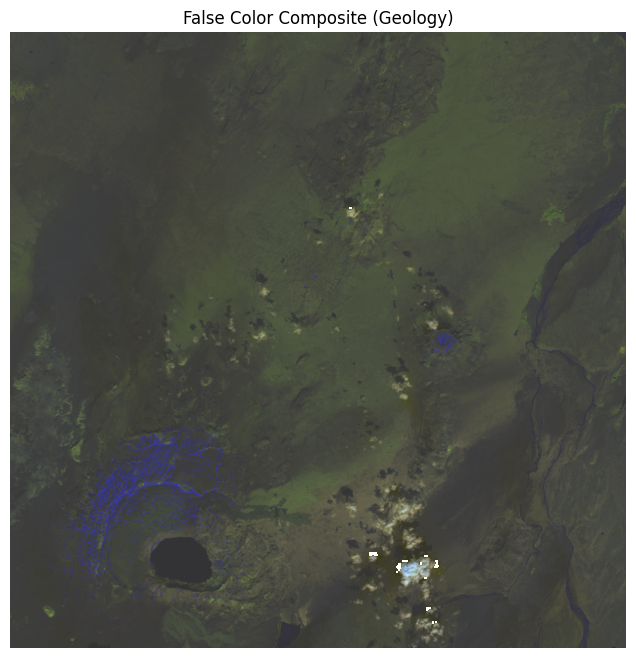

In [20]:
rgb_bands = [iceland[5, :, :], iceland[4, :, :], iceland[0, :, :]]

rgb_image = np.dstack(rgb_bands)
rgb_norm = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image))
# Plot the RGB image
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.imshow(rgb_norm)
plt.title('False Color Composite (Geology)')
plt.axis('off')  # Optional: Turn off axes
plt.show()